# Parallelizing Python with Dask. 

[Dask](http://dask.pydata.org/) is a library for parallel and distributed computing in Python. As mentioned in the Introduction, one of the main limitations of Python is that in most cases, a single Python interpreter can only access a single thread of computation at a time . This is because of the so-called Global
Interpreter Lock (or [GIL](https://docs.python.org/3/glossary.html#term-global-interpreter-lock)).

And while there is a [multiprocessing module](https://docs.python.org/3/library/multiprocessing.html) in the Python standard library, it's use is cumbersome and often requires complicated decisions. Dask simplifies this substantially, by making the code simpler, and by making these decisions for you.


### Dask delayed computation:

Let's look at a simple example. The following are some very fast and simple calculations, and we add some `sleep` into them, to simulate a compute-intensive task that takes some time to complete:


In [1]:
import time

def inc(x):
    time.sleep(1)
    return x + 1

def add(x, y):
    time.sleep(1)
    return x + y

How much time would it take to perform the following computation? 

    x1 = inc(1)
    x2 = inc(2)
    z = add(x1, x2)

Let's profile it:

In [2]:
%%time 
x1 = inc(1)
x2 = inc(2)
z = add(x1, x2)

CPU times: user 8.32 ms, sys: 6.21 ms, total: 14.5 ms
Wall time: 3 s


> Notice that we're using the `%%time` magic here, which only times one run of the code. If we want this estimate to be more accurate, it's better to run `%%timeit`, but that also takes longer, because it does several repeats.

But does it have to take this long? Notice that while `z` depends on both `x1` and `x2`, there is no dependency between `x1` and `x2`. In principle, we could compute both of them in parallel, but Python doesn't do that out of the box. One way to convince Python to parallelize these is by telling Dask in advance about the dependencies between different variables, and letting it infer how to distribute the computations across threads.

To enable this, we have to start by preprocessing our *functions*. The Python language has a notion of a *decorator*. This is a function that takes functions as inputs and produces functions as outputs, while doing something to them in the interim. In the case of dask's "delayed" decorator, it does something a bit odd: it makes it so that the function is not executed, until the subsequent consequences of running this function are well understood by dask. If that sounds odd, it will become clear soon. 

Let's start by creating the decorated versions of the functions we defined above:

In [3]:
from dask import delayed

delayed_inc = delayed(inc)
delayed_add = delayed(add)

Now, we compute our result in a delayed fashion:

In [4]:
x1 = delayed_inc(1)
x2 = delayed_inc(2)
z = delayed_add(x1, x2)

Note that running that cell by itself took no time at all. On the other hand, there's also no result yet: 

In [5]:
z

Delayed('add-1d3efa17-013e-4692-a9b8-a0bdcedb29cf')

For now, all we have is an object that doesn't have a value, but that knows how to get its value once it will be asked for it. It can even report about the computational dependencies that will lead to its eventual materialization:

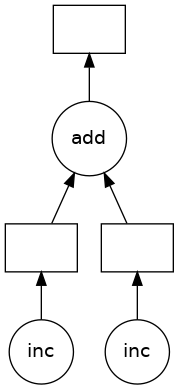

In [6]:
z.visualize()

This is neat. The graph that was created includes the understanding that the two increment operations are independent and can proceed in parallel, and that it is only addition depends on the results of these computations and needs to wait for them. How long do you think the computation will take this time?

In [7]:
%%time 
result = z.compute()

CPU times: user 4 ms, sys: 4.74 ms, total: 8.74 ms
Wall time: 2.01 s


And now, we also have the value: 

In [8]:
result

5

This simple example is really the basis for everything that Dask does. However, much of its strength comes from the fact that it applies these ideas in a way that is tailored to computations that scientists might want to do. For example, Dask has implementations of several commonly-used Pytho data-structures. In particular, it implements a data structure that resembles the Numpy Array object and another data structure that resembles the Pandas DataFrame. This lets us do slightly more interesting things and leverage our knowledge of these tools.